# Understanding the execution flow from `LightningQubit`

In [1]:
from typing import Iterable, Union
import quimb.tensor as qtn
import pennylane as qml
from pennylane.wires import Wires
import numpy as np

/home/pietropaolo.frisoni/anaconda3/envs/PennyLane/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:34: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


## Choosing a tape

In [2]:
theta = 0.1
phi = 0.2

O1 = qml.Identity(wires=[0])
O2 = qml.PauliZ(wires=[1])

ops = [
    qml.DoubleExcitation(phi, wires=[12, 11, 0, 9]),
    qml.PauliX(wires=[0]),
    qml.RX(theta, wires=[0]),
    qml.CSWAP(wires=[7, 0, 5]),
    qml.RX(phi, wires=[1]),
    qml.CNOT(wires=[3, 4]),
    qml.DoubleExcitation(phi, wires=[1, 2, 3, 4]),
    qml.CSWAP(wires=[0, 1, 2]),
    qml.Hadamard(wires=[4]),
    qml.CSWAP(wires=[2, 3, 4]),
    qml.CNOT(wires=[2, 4]),
    qml.DoubleExcitation(phi, wires=[0, 1, 3, 4]),
]

meas = [
    qml.expval(O2),
    qml.expval(O2),
    qml.var(qml.PauliY(wires=[2])),
    qml.expval(O1),
    qml.var(qml.PauliY(wires=[4])),
]


tape = qml.tape.QuantumScript(ops=ops, measurements=meas)

## Learning from `LightningQubit` using Python API

In [3]:
from pennylane_lightning.lightning_qubit import LightningQubit

In [4]:
obj = LightningQubit(wires=tape.wires)

ImportError: Pre-compiled binaries for lightning.qubit are not available. To manually compile from source, follow the instructions at https://pennylane-lightning.readthedocs.io/en/latest/installation.html.

In [ ]:
obj.tracker

In [ ]:
program, config = obj.preprocess()

In [ ]:
program[0]

<validate_measurements([], {'name': 'lightning.qubit'})>

In [ ]:
obj.execute(tape)

(0.9999502079587257, 0.9999502079587257, 0.9901818584603551, 1.0, 1.0)

## Testing `LightningTensor` 

In [ ]:
wires = tape.wires
backend = "quimb"
method = "mps"
c_dtype = np.complex128
max_bond_dim = None
cutoff = 0.0

In [ ]:
from pennylane_lightning.lightning_tensor import LightningTensor


@qml.qnode(LightningTensor(contract="auto-mps"))
def circuit():
    qml.X(0)
    return qml.expval(qml.Z(0))


circuit()

call chiamata


tensor(-1., requires_grad=True)

In [38]:
from pennylane_lightning.lightning_tensor import LightningTensor
import jax
import jax.numpy as jnp

from pennylane.devices import DefaultExecutionConfig, Device, ExecutionConfig

# dev = qml.device("default.qubit.jax", wires=1)

dev = LightningTensor(wires=qml.wires.Wires(range(1)))


@qml.qnode(dev, interface="jax")
def circuit(x):
    qml.RX(x[1], wires=0)
    qml.Rot(x[0], x[1], x[2], wires=0)
    return qml.expval(qml.Z(0))


weights = jnp.array([0.2, 0.5, 0.1])
grad_fn = jax.grad(circuit)
print(grad_fn(weights))

circuit(weights)


@jax.jit
@qml.qnode(dev, interface="jax")
def circuit():
    qml.Hadamard(0)
    return qml.expval(qml.Z(0))


circuit()

(Traced<ConcreteArray([0.2 0.5 0.1], dtype=float32)>with<JVPTrace(level=2/0)> with
  primal = Array([0.2, 0.5, 0.1], dtype=float32)
  tangent = Traced<ShapedArray(float32[3])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float32[3]), None)
    recipe = LambdaBinding(),)
{}
[-2.2526717e-01 -1.0086455e+00  8.6099212e-17]
(Array([0.2, 0.5, 0.1], dtype=float32),)
{}
()
{}


Array(-2.2371143e-17, dtype=float32, weak_type=True)

In [ ]:
_, conf = dev.preprocess()

In [ ]:
conf

ExecutionConfig(grad_on_execution=True, use_device_gradient=False, use_device_jacobian_product=None, gradient_method=None, gradient_keyword_arguments={}, device_options={'rng': Generator(PCG64) at 0x76ED958E7200, 'c_dtype': <class 'numpy.complex128'>, 'batch_obs': False, 'mcmc': False, 'kernel_name': None, 'num_burnin': 0}, interface=None, derivative_order=1)

In [ ]:
exec_config = dev._setup_execution_config(DefaultExecutionConfig)

In [ ]:
exec_config

ExecutionConfig(grad_on_execution=True, use_device_gradient=False, use_device_jacobian_product=None, gradient_method=None, gradient_keyword_arguments={}, device_options={'rng': Generator(PCG64) at 0x76ED958E7BA0, 'c_dtype': <class 'numpy.complex128'>, 'batch_obs': False, 'mcmc': False, 'kernel_name': None, 'num_burnin': 0}, interface=None, derivative_order=1)

In [ ]:
h = qml.Hamiltonian(...)


@qml.qnode(dev)
def f(x):
    ...
    return qml.expval(h), qml.var(qml.Z(0) @ qml.Z(1))


f(x)  # Use smart defaults for execution config
f(
    x, config={"max_bond_dim": 5, "cutoff": 1e-5}
)  # Any execution config specified by the user overrides the default

In [ ]:
obj = LightningTensor(
    wires=wires,
    backend=backend,
    method=method,
    c_dtype=c_dtype,
    max_bond_dim=max_bond_dim,
    cutoff=cutoff,
)

In [ ]:
obj._interface.state

MatrixProductState(tensors=10, indices=19, L=10, max_bond=2)

In [ ]:
# obj._interface._circuitMPS.get_psi_reverse_lightcone(3)

In [ ]:
type(obj._setup_execution_config())

pennylane.devices.execution_config.ExecutionConfig

In [ ]:
program, config = obj.preprocess()

In [ ]:
program[0]

<validate_measurements([], {'name': 'QuimbMPS interface'})>

In [ ]:
config

ExecutionConfig(grad_on_execution=None, use_device_gradient=None, use_device_jacobian_product=None, gradient_method=None, gradient_keyword_arguments={}, device_options={'backend': 'quimb', 'c_dtype': <class 'numpy.complex128'>, 'contract': 'auto-mps', 'cutoff': 0.0, 'method': 'mps', 'max_bond_dim': None}, interface=None, derivative_order=1)

In [ ]:
obj.execute(circuits=tape)

(0.999950207958725,
 0.999950207958725,
 0.9901818584603544,
 0.9999999999999991,
 0.9999999999999993)

# Playing with `quimb`

## MPS

In [ ]:
wires = Wires(range(7))
init_state = qtn.MPS_computational_state(
    "0" * len(wires), tags=[str(l) for l in wires.labels]
)
qc = qtn.CircuitMPS(psi0=init_state)

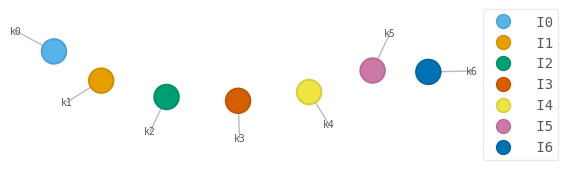

In [ ]:
qc.psi.draw(color=[f"I{q}" for q in range(len(wires))], show_tags=False, show_inds=True)

In [ ]:
init_state

MatrixProductState(tensors=7, indices=13, L=7, max_bond=2)

In [ ]:
qc.__dict__

{'_psi': MatrixProductState(tensors=7, indices=13, L=7, max_bond=2),
 'N': 7,
 'tag_gate_numbers': False,
 'tag_gate_rounds': False,
 'tag_gate_labels': False,
 'to_backend': None,
 '_backend_gate_cache': None,
 'gate_opts': {'contract': 'auto-mps',
  'propagate_tags': False,
  'max_bond': None,
  'cutoff': 1e-10,
  'info': {}},
 'gates': [],
 '_ket_site_ind_id': 'k{}',
 '_bra_site_ind_id': 'b{}',
 'ket_site_ind': <function str.format>,
 'bra_site_ind': <function str.format>,
 '_sample_n_gates': -1,
 '_storage': {},
 '_sampled_conditionals': {}}

## TN

In [ ]:
wires = Wires(range(7))
init_state = qtn.TN_from_sites_computational_state(
    site_map={i: "0" for i in range(len(wires))}
)
qc = qtn.Circuit(psi0=init_state)

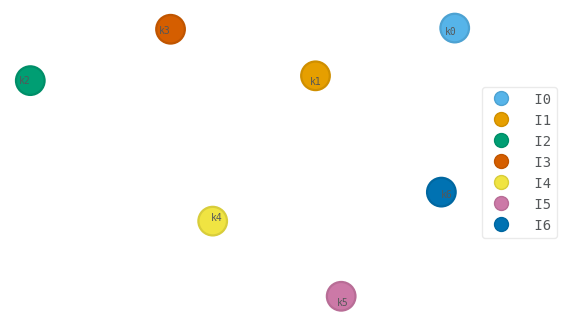

In [ ]:
qc.psi.draw(color=[f"I{q}" for q in range(len(wires))], show_tags=False, show_inds=True)

In [ ]:
qc.__dict__

{'_psi': TensorNetworkGenVector(tensors=7, indices=7),
 'N': 7,
 'tag_gate_numbers': True,
 'tag_gate_rounds': True,
 'tag_gate_labels': True,
 'to_backend': None,
 '_backend_gate_cache': None,
 'gate_opts': {'contract': 'auto-split-gate', 'propagate_tags': 'register'},
 'gates': [],
 '_ket_site_ind_id': 'k{}',
 '_bra_site_ind_id': 'b{}',
 'ket_site_ind': <function str.format>,
 'bra_site_ind': <function str.format>,
 '_sample_n_gates': -1,
 '_storage': {},
 '_sampled_conditionals': {}}

In [ ]:
op = qml.RX(0.5, wires=[1])

qc.apply_gate(op.matrix(), *op.wires)

In [ ]:
qc.__dict__

{'_psi': TensorNetworkGenVector(tensors=8, indices=8),
 'N': 7,
 'tag_gate_numbers': True,
 'tag_gate_rounds': True,
 'tag_gate_labels': True,
 'to_backend': None,
 '_backend_gate_cache': None,
 'gate_opts': {'contract': 'auto-split-gate', 'propagate_tags': 'register'},
 'gates': [<Gate(label=RAW130160914910544, params=raw, qubits=(1,))>],
 '_ket_site_ind_id': 'k{}',
 '_bra_site_ind_id': 'b{}',
 'ket_site_ind': <function str.format>,
 'bra_site_ind': <function str.format>,
 '_sample_n_gates': -1,
 '_storage': {},
 '_sampled_conditionals': {}}

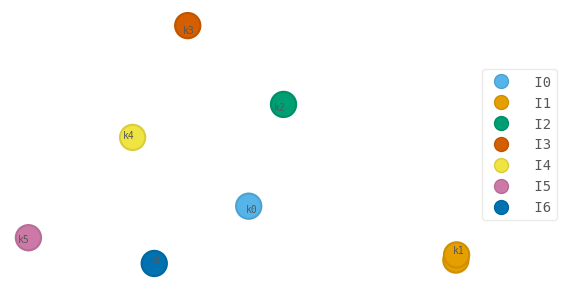

In [ ]:
qc.psi.draw(color=[f"I{q}" for q in range(len(wires))], show_tags=False, show_inds=True)